In [3]:
# songs: gnossi_1.mp3, henne_song.mp3, Blumen.wav, Misty.mp3, gnossi_1_full.mp3
# Präludium_1_bach.mp3, Präludium_2_Bach.mp3


#song_name = "songs/gnossi_1.mp3"
#song_name = "songs/henne_song.mp3"
#song_name = "songs/Präludium_1_bach.mp3"
#song_name = "songs/Präludium_2_Bach.mp3"
#song_name = "songs/Blumen.wav"
#song_name = "songs/Misty.mp3"
#song_name = "songs/space_is_the_place_men_I_trust.mp3"
song_name = "songs/opus_men_I_trust.mp3"

# general params
fps = 15
boost_fps = 60
# musicnn params
input_overlap = 1 / 30
input_length = 3
# song params
offset = 0
duration = None
# post processing params
upscale = True
twice_upscale = False
# video params
total_effect_strength = 0.42
ema_val = 0.3 # 0.99 is too strong
ema_val_latent = 0.3
sub_steps = 50
lpips_weight = 0.15
# prompts
base_img_path = "../CLIP_playground/base_images/"
# settings for prompts
k = 5
prompt_mode = "top_k" # top_k, weighted_top_k, gpt
taggram_mode = "feelings" # full, feelings
prefix = ""
general_theme = ". In the style of James Gurney."
create_gpt_artstyle = False
create_clusters = True
do_create_gpt_cluster_stories = True
cluster_k = 8  # number of K-Means clusters to form over all musicnn predictions
gpt_story_top_k = 3  # number of k top cluster stories that will be consideren in CLIP guidance
img_theme = None # base_img_path + "hot-dog.jpg"
# base_img_path + "Autumn_1875_Frederic_Edwin_Church.jpg"
#". By Pete Mohrbacher."
#". In the style of 'The Persistence of Memory' by Dali." #" by madziowa_p." #" by Jan Brueghel the Elder."  #" by Salvador Dali." #" by Greg Rutkowski."


In [4]:
import soundfile
import librosa
import os

resampled_path = "tmp/resampled.wav"
os.makedirs("tmp", exist_ok=True)

# load song and resample to 16k Hz
sr = 16000
raw_song, old_sr = librosa.load(song_name, offset=offset, duration=duration)
song = librosa.resample(raw_song, old_sr, sr)
soundfile.write(resampled_path, song, sr)

/home/anton/.local/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [3]:
import musicnn
from musicnn.extractor import extractor
from musicnn.tagger import top_tags
import pandas as pd

#remove deprecation warnings
#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

def get_taggram(resampled_path, input_overlap):
    #MTT_musicnn', 'MTT_vgg', 'MSD_musicnn', 'MSD_musicnn_big' or 'MSD_vgg'.
    taggram_msd, tags_msd = extractor(resampled_path, model='MSD_musicnn_big', extract_features=False, 
                                      input_overlap=input_overlap, input_length=input_length)
    taggram_mtt, tags_mtt = extractor(resampled_path, model='MTT_musicnn', extract_features=False, 
                                      input_overlap=input_overlap, input_length=input_length)
    # clear cuda
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    # merge taggrams
    tag_df_msd = pd.DataFrame(taggram_msd, columns=tags_msd)
    tag_df_mtt = pd.DataFrame(taggram_mtt, columns=tags_mtt)
    tag_df = pd.concat([tag_df_msd, tag_df_mtt], axis=1)
    # merge beat (before normalization because we merged them before calculating the stds)
    tag_df["Beat"] = (tag_df["beat"] + tag_df["beats"]) / 2
    tag_df = tag_df.drop(columns=["beat", "beats"])
    # identify duplicated columns
    duplicated_cols = set()
    for col in tag_df.columns:
        if isinstance(tag_df[col], pd.DataFrame):
            duplicated_cols.add(col)
    # average duplicated columns
    for duplicated_col in list(duplicated_cols):
        averaged = tag_df[duplicated_col].mean(axis=1)
        del tag_df[duplicated_col]
        tag_df[duplicated_col] = averaged
    # normalize taggram by std on the MTT dataset
    mtt_stds = pd.read_csv("data/mtt/mtt_stds.csv", header=None, index_col=0, squeeze=True).iloc[1:]
    normed_tag_df = tag_df / mtt_stds
    # merge some more columns
    merge_dict = {("male vocal", "male voice", "male vocalists"): "male vocal",
                  ("female vocal", "female voice", "female vocalists"): "female vocal",
                  ("vocal", "vocals", "voice"): "vocal",
                  ("no vocal", "no vocals", "no voice"): "no vocal",
                  ("electro", "electronic"): "electro",
                  ("choir", "choral"): "choral", 
                 }
    print(normed_tag_df.columns)
    for cols_to_merge in merge_dict:
        cols_to_merge_list = list(cols_to_merge)
        merged_col = normed_tag_df[cols_to_merge_list].to_numpy().mean(axis=1)
        normed_tag_df = normed_tag_df.drop(columns=cols_to_merge_list)
        normed_tag_df[merge_dict[cols_to_merge]] = merged_col
    return normed_tag_df
    
    
tag_dfs_folder = "./tmp/tag_dfs"
os.makedirs(tag_dfs_folder, exist_ok=True)
key_song_name = song_name.split("/")[-1].split(".")[0]
tag_df_name = f"{key_song_name}_{input_length}_{int(1 / input_overlap)}_{offset}_{duration}.csv"
tag_df_path = os.path.join(tag_dfs_folder, tag_df_name)
if os.path.exists(tag_df_path):
    normed_tag_df = pd.read_csv(tag_df_path, index_col=0)
else:
    normed_tag_df = get_taggram(resampled_path, input_overlap)
    normed_tag_df.to_csv(tag_df_path)

In [4]:
#normed_tag_df.T.mean(axis=1).sort_values(ascending=False).iloc[:15].plot.barh(figsize=(5, 5))

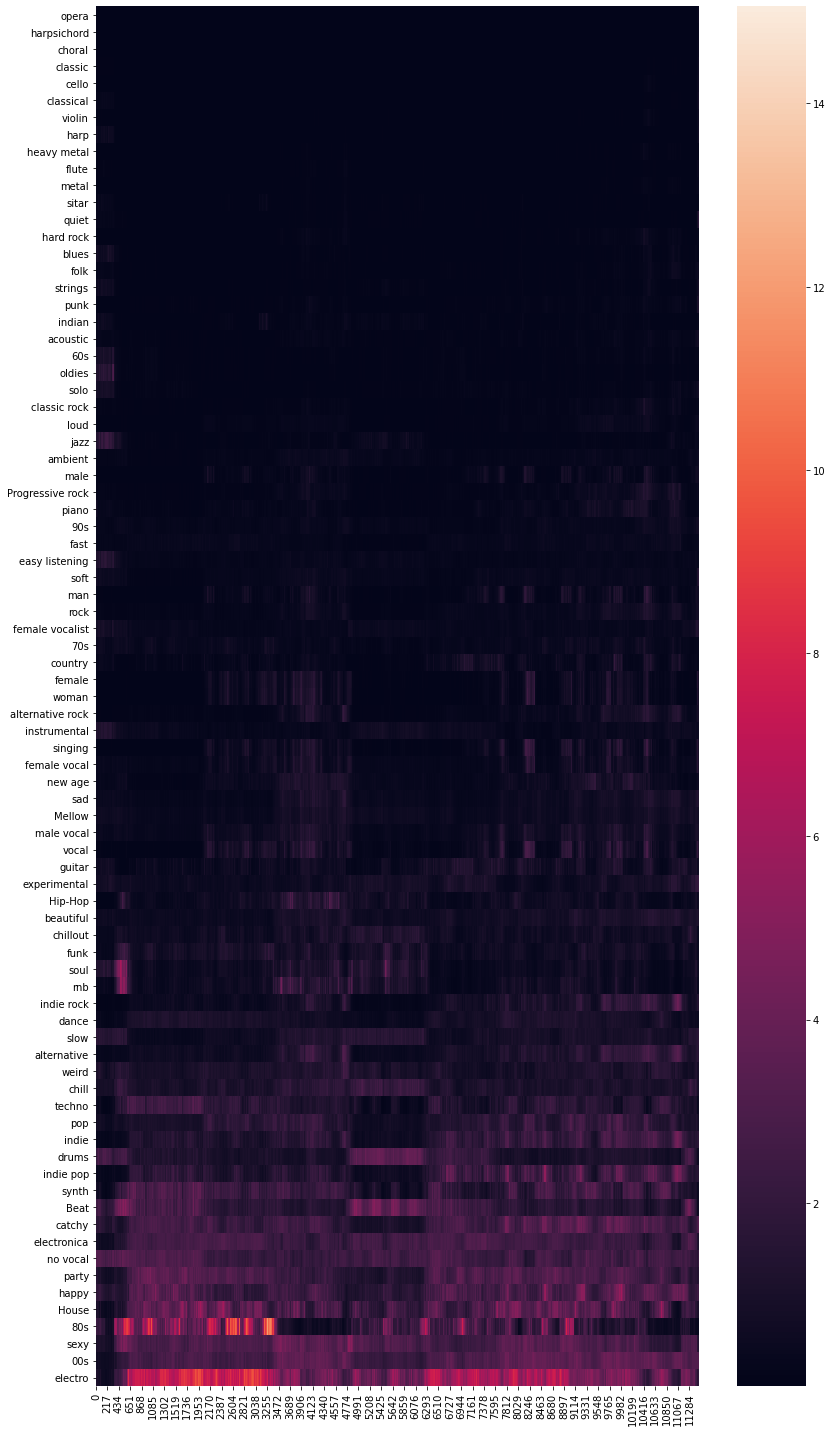

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# alphabetic
#plt.figure(figsize=(13, 20))
#sns.heatmap(normed_tag_df.T)
#plt.tight_layout()
# ordered by importance
plt.figure(figsize=(12, 20))
show_df = normed_tag_df.T.copy()
show_df["mean"] = normed_tag_df.mean(axis=0)
show_df = show_df.sort_values("mean").drop(columns=["mean"])
sns.heatmap(show_df)
plt.tight_layout()

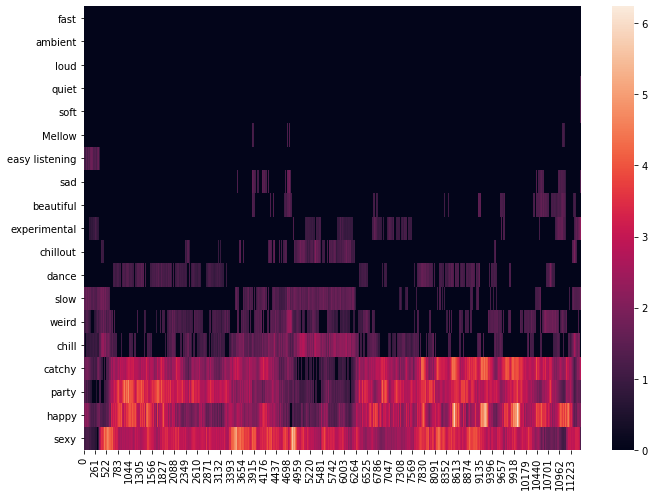

In [6]:
instruments = ["violin", "strings", "sitar", "piano", "harpsichord", 
               "harp", "guitar", "drums", "flute", "synth", "cello"]
genres = ["techno", "soul", "rock", "rnb", "punk", "pop", "opera", 
          "oldies", "new age", "metal", "jazz", "indie rock", "indie pop",
          "indie", "indian", "heavy metal", "hard rock", "funk", "folk", 
          "electronica", "electronic", "country", "classical", "classic rock",
          "classic", "choral", "blues", "alternative rock", "alternative",
          "Progressive rock", "House", "Hip-hop"]
eras = ["60s", "70s", "80s", "90s", "00s"]

speed_tags = ["fast", "slow"]
feeling_tags = ["weird", "soft", "happy", "sad", "catchy", "easy listening", "sexy", "chillout", "beautiful", "chill"]
loudness_tags = ["quiet", "loud"]
vibe_tags = ["ambient", "party", "dance", "Mellow", "experimental"]

genre_like_tags = ["solo", "blues", "Beat"]

feeling_tags = speed_tags + feeling_tags + loudness_tags + vibe_tags
    
plt.figure(figsize=(10, 7))
show_df = normed_tag_df[feeling_tags].T.copy()
show_df[show_df < show_df.mean(axis=0)] = 0
show_df["mean"] = show_df.mean(axis=1)
show_df = show_df.sort_values("mean").drop(columns=["mean"])
sns.heatmap(show_df)
plt.tight_layout()

In [7]:
import numpy as np

def get_spec_norm(song):
    mel_spec = librosa.feature.melspectrogram(song, sr=16000, S=None, 
                                              n_fft=512, hop_length=256, 
                                              win_length=None, window='hann', center=True, 
                                              pad_mode='reflect', power=2.0)
    # Obtain maximum value per time-frame
    spec_max = np.amax(mel_spec, axis=0)
    #print(spec_max.shape)
    # Normalize all values between 0 and 1
    mel_spec = (mel_spec - np.min(spec_max)) / np.ptp(spec_max)

    #mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())
    #sns.heatmap(mel_spec[:20, :])
    return mel_spec.mean(axis=0)

In [8]:
import torch

def gpt_create_prompt(model, tokenizer, merged_top_tags, num_beams=6, top_p=0.80):
    gpt_prompt = f"""The following are adjectives describing a song (in order of importance), followed by a description of a corresponding image:
Song description: fast, guitar, sad. Corresponding image description: A biker is racing on his motorbike while crying.
Song description: loud, techno, electronic. Corresponding image description: An illustration of dynamic and vibrant colors forming geometric shapes.
Song description: {merged_top_tags}. Corresponding image description:"""
    
    prompter = ". Image description:"
    gpt_prompt_1 = f"""The following are adjectives describing a song, followed by a description of the corresponding image:
fast, guitar, sad{prompter} An amazing painting of a man running through dark woods while crying.
loud, techno, electronic{prompter} A breathtaking illustration of dynamic and vibrant colors forming geometric shapes that give the impression of a dance.
slow, soft, beautiful, sad, quiet{prompter} This is a beautiful painting of an old woman who is sitting on a chair with her hands folded in front of her. She is looking at you with a sad expression on her face.
{merged_top_tags}{prompter}"""

    
    out = model.generate(tokenizer.encode(gpt_prompt_1, return_tensors="pt").to(model.device),
                         top_p=top_p, do_sample=True, output_scores=True, 
                         return_dict_in_generate=True, 
                         max_length=190,
                         num_beams=num_beams, 
                         no_repeat_ngram_size=2,)
    out_text = tokenizer.decode(out["sequences"].tolist()[0])
    #print(out_text.split("Corresponding image description:")[3:])
    clip_prompt = out_text.split(prompter)[-1].split("\n")[0].strip().strip('<|endoftext|>')
    if not clip_prompt.endswith("."):
        clip_prompt = ".".join(clip_prompt.split(".")[:-1]) + "."
    return clip_prompt

def gpt_create_prompt_2(model, tokenizer, merged_top_tags, num_beams=5):
    prompter = "This is the full description of the image: "
    gpt_prompt = f"""These are some adjectives describing an image: {merged_top_tags}. {prompter}"""

    
    out = model.generate(tokenizer.encode(gpt_prompt, return_tensors="pt").to(model.device),
                         top_p=0.95, do_sample=True, output_scores=True, 
                         return_dict_in_generate=True, 
                         max_length=130,
                         num_beams=num_beams, 
                         no_repeat_ngram_size=2,)
    out_text = tokenizer.decode(out["sequences"].tolist()[0])
    #print(out_text.split("Corresponding image description:")[3:])
    clip_prompt = out_text.split(prompter)[1].strip().strip('<|endoftext|>').strip("\n")
    return clip_prompt


In [9]:
# to test prompts
#from transformers import GPTNeoForCausalLM, GPT2Tokenizer
#from transformers import GPT2LMHeadModel
#device = torch.device("cuda")
#gpt_tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
#gpt_model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B", pad_token_id=gpt_tokenizer.eos_token_id)
#gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#gpt_model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=gpt_tokenizer.eos_token_id)
#gpt_model = gpt_model.to(device)

In [10]:
#gpt_create_prompt(gpt_model, gpt_tokenizer, ",".join(themes[0]), num_beams=5)

In [11]:
#themes = [['chill', 'sexy', 'chillout', 'slow', 'Mellow'],
# ['slow', 'soft', 'sad', 'beautiful', 'quiet'],
# ['beautiful', 'sad', 'slow', 'soft', 'Mellow'],
# ['chillout', 'chill', 'party', 'sexy', 'weird'],
# ['sexy', 'chill', 'slow', 'chillout', 'happy'],
# ['quiet', 'catchy', 'soft', 'happy', 'sad'],
# ['chill', 'slow', 'chillout', 'beautiful', 'Mellow'],
# ['slow', 'soft', 'beautiful', 'sad', 'quiet']]
#for theme in themes:
#    out = gpt_create_prompt(gpt_model, gpt_tokenizer, ",".join(theme), num_beams=6, top_p=0.80)
#    print(theme, out, "\n")

In [12]:
def gpt_create_prompt_3(model, tokenizer, merged_top_tags, num_beams=5):
    gpt_prompt = f"""The words 'sad, beautiful, happy' can be summarized by this sentence:
        The beautiful girl walks sadly through the happy crowd.
    
    The words '{merged_top_tags}' can be summarized by this sentence:
        """
    
    out = model.generate(tokenizer.encode(gpt_prompt, return_tensors="pt").to(model.device),
                         top_p=0.95, do_sample=True, output_scores=True, 
                         return_dict_in_generate=True, 
                         max_length=120,
                         num_beams=num_beams, 
                         no_repeat_ngram_size=2,)
    out_text = tokenizer.decode(out["sequences"].tolist()[0])
    #print(out_text.split("Corresponding image description:")[3:])
    clip_prompt = out_text.split("\n")[4].split("\n")[0].strip().strip('<|endoftext|>')
    return clip_prompt, out_text

In [13]:
# reduce taggram to fit fps
musicnn_fps = 62.5
#averaging_window = int(musicnn_fps / fps) # == 2 - 30fps
averaging_window = int(np.round(musicnn_fps / fps)) # == 3 - 20fps
# take step average taggram
fps_taggram = normed_tag_df.rolling(averaging_window, min_periods=1, axis=0).mean() 
fps_taggram = fps_taggram.iloc[::averaging_window, :]

In [14]:
# decide on using only subset
used_tag_df = fps_taggram.copy()
if taggram_mode == "feelings":    
    used_tag_df = used_tag_df[feeling_tags]

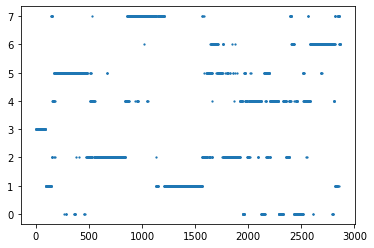

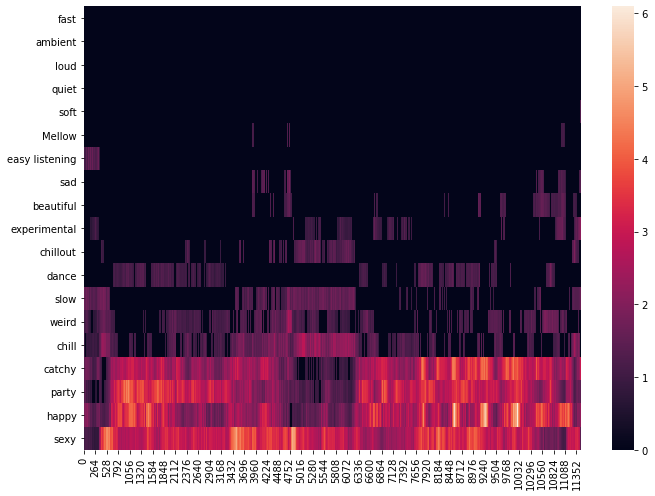

In [15]:
# create clusters
if create_clusters:
    from umap import UMAP
    clustering_feats = used_tag_df.to_numpy()
    # create high dim umap embeddings for clustering
    cluster_on_umap_high_d = False
    if cluster_on_umap_high_d:
        print("Umapping...")
        clusterable_embedding = UMAP(
            n_neighbors=30,
            min_dist=0.0,
            n_components=10,
            random_state=42,
            metric="cosine",
        ).fit_transform(clustering_feats)
    else:
        clusterable_embedding = clustering_feats
    
    # cluster
    #import hdbscan
    #labels = hdbscan.HDBSCAN(
    #    min_samples=10,
    #    min_cluster_size=10,
    #).fit_predict(clusterable_embedding)  
    #print("Num clusters: ", len(np.unique(labels)) - 1)
    import sklearn
    clusterer = sklearn.cluster.KMeans(n_clusters=cluster_k)
    labels = clusterer.fit_predict(clusterable_embedding)
    centers = clusterer.cluster_centers_

    dist_to_centers = np.array([np.mean((emb - centers) ** 2, axis=-1) for emb in clusterable_embedding])
    dist_to_centers = torch.from_numpy(dist_to_centers)
    
    show_2d_umap = False
    if show_2d_umap:
        # create 2D UMAP embedding to plot
        mapper = UMAP(
            n_neighbors=30,
            min_dist=0.0,
            n_components=2,
            random_state=42,
            metric="cosine",
        ).fit(clustering_feats)
        # make plot
        import umap.plot
        umap.plot.output_notebook()
        df = pd.DataFrame({"step": list(range(len(labels))),
                           "cluster": labels,
                           })
        p = umap.plot.interactive(mapper, 
                                  labels=df["cluster"], 
                                  #values = df["step"],
                                  hover_data=df, point_size=10)
        umap.plot.show(p)
    # show clusters over time
    import matplotlib.pyplot as plt
    plt.scatter(range(len(labels)), labels, s=1.5)
    plt.show()
    # show heatmap 
    plt.figure(figsize=(10, 7))
    show_df = used_tag_df[feeling_tags].T.copy()
    show_df[show_df < show_df.mean(axis=0)] = 0
    show_df["mean"] = show_df.mean(axis=1)
    show_df = show_df.sort_values("mean").drop(columns=["mean"])
    sns.heatmap(show_df)
    plt.tight_layout()

In [16]:
# highest_classification
center_df = pd.DataFrame(centers, columns=used_tag_df.columns)

cluster_themes = []
for i in range(len(center_df)):
    cluster_theme = center_df.iloc[i].sort_values(ascending=False)[:5].index.to_list()
    print(str(i) + ":",  ", ".join(cluster_theme))
    cluster_themes.append(cluster_theme)

0: happy, catchy, party, sexy, dance
1: sexy, chill, happy, slow, party
2: party, sexy, catchy, happy, chill
3: happy, catchy, slow, easy listening, sexy
4: sexy, catchy, party, happy, dance
5: party, happy, catchy, sexy, dance
6: happy, catchy, party, sexy, weird
7: sexy, catchy, happy, party, chill


In [17]:
main_theme = used_tag_df.mean().sort_values(ascending=False)[:5]
main_theme_words = main_theme.index.to_list()
main_theme

sexy      2.955625
happy     2.575655
party     2.538893
catchy    2.393136
chill     1.296489
dtype: float64

In [18]:
# main distinctive features 
print(str(i) + ":",  ", ".join(center_df.std().sort_values(ascending=False)[:5].index.to_list()))

7: happy, party, catchy, sexy, chill


In [19]:
import IPython

# listen to clusters

cluster_idx = 0

samples_per_step = int(len(song) / len(labels)) + 1

frame_assignments = []
for label in labels:
    frame_assignments.extend([label] * samples_per_step)
frame_assignments = np.array(frame_assignments)

sections = frame_assignments == cluster_idx

song_section = song[sections[:len(song)]]

IPython.display.Audio(song_section, rate=sr, autoplay=False)

In [20]:
len(labels)

2866

In [21]:
def create_gpt_cluster_stories(cluster_words_list):
    from transformers import GPTNeoForCausalLM, GPT2Tokenizer
    from transformers import GPT2LMHeadModel
    device = torch.device("cuda")
    gpt_tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
    gpt_model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B", pad_token_id=gpt_tokenizer.eos_token_id)
    
    gpt_stories = []
    for cluster_words in cluster_words_list:
        cluster_story = gpt_create_prompt(gpt_model, gpt_tokenizer, cluster_words)
        gpt_stories.append(cluster_story)
        print(cluster_story)
    return gpt_stories

In [22]:
cluster_gpt_stories = None
if do_create_gpt_cluster_stories:
    cluster_gpt_stories = create_gpt_cluster_stories(cluster_themes)

/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The image shows a young girl dancing in a room full of people. The girl is wearing a pink dress and a pair of red high heels.
The image shows a young woman wearing a black dress and holding a glass of red wine in her hand.
The lyrics of this song describe the feeling of being caught up in the moment. The image shows a young girl dancing in a room full of people.
The image shows a young girl playing a guitar. The girl is smiling and playing the guitar in a way that makes it look like she is having a good time.
The image is of two young girls dancing in a nightclub. One of them is wearing a short skirt while the other has a long dress. The girls are smiling and dancing to the music.
The image shows a group of people dancing in a nightclub. The music is loud and the people are dancing to the music.
The image shows a group of people dancing in a crowded room. The music is loud and the dance moves are fast.
The image shows a young man with his arm around a girl. The girl is wearing a red dr

In [23]:
cluster_themes

[['happy', 'catchy', 'party', 'sexy', 'dance'],
 ['sexy', 'chill', 'happy', 'slow', 'party'],
 ['party', 'sexy', 'catchy', 'happy', 'chill'],
 ['happy', 'catchy', 'slow', 'easy listening', 'sexy'],
 ['sexy', 'catchy', 'party', 'happy', 'dance'],
 ['party', 'happy', 'catchy', 'sexy', 'dance'],
 ['happy', 'catchy', 'party', 'sexy', 'weird'],
 ['sexy', 'catchy', 'happy', 'party', 'chill']]

In [24]:
def gpt_create_style(model, tokenizer, theme_words, num_beams=5):
    prompter = "The name of a matching painter is:"
    #gpt_prompt = f"""I am an artificial intelligence that can tell you a matching artist (even little known ones) for a set of words describing a painting.
    gpt_prompt = f"""The following are lists of words describing art, followed by the name of the artist:
    
    The art fits these terms: expressionist, beautiful, vibrant. {prompter} Van Gogh.
    The art fits these terms: epic, fantasy, stunning, beautiful, moody. {prompter} Greg Rutkowski.
    The art fits these terms: realistic, beautiful, landscapes, dinosaurs, forgotten civilizations. {prompter} James Gurney.
    The art fits these terms: {theme_words}. {prompter}"""
    
    gpt_prompt = f"""The following are lists of words describing art, followed by the name of the artist:
    
    expressionist, beautiful, vibrant. {prompter} Van Gogh.
    epic, fantasy, stunning, beautiful, moody. {prompter} Greg Rutkowski.
    realistic, beautiful, landscapes, dinosaurs, forgotten civilizations. {prompter} James Gurney.
    {theme_words}. {prompter}"""

    #gpt_prompt = f"""I am an artificial intelligence that can tell you a matching artist (even little known ones) for a set of words describing a painting.
    #The painting fits these terms: {theme_words}. {prompter}"""
    
    #prompter = "He would suggest the artist:"
    #gpt_prompt = f"""An interview with a world-famous art expert. He can tell you an artist with a matching style for a set of words describing a painting.
    #For painting fiting these terms: {theme_words}. {prompter}"""
    
    #prompter = " This painting has been painted by a painter with the name"
    #gpt_prompt = f"""I would describe this painting as {theme_words}. {prompter}"""

    
    out = model.generate(tokenizer.encode(gpt_prompt, return_tensors="pt").to(model.device),
                         top_p=0.98, do_sample=True, output_scores=True, 
                         return_dict_in_generate=True, 
                         max_length=200,
                         num_beams=num_beams, 
                         no_repeat_ngram_size=2,)
    out_text = tokenizer.decode(out["sequences"].tolist()[0])
    #print(out_text.split("Corresponding image description:")[3:])
    clip_prompt = out_text.split(prompter)[-1].split("\n")[0].strip().strip("\n")
    while len(clip_prompt) > 25:
        clip_prompt = ".".join(clip_prompt.split(".")[:-1])
    return clip_prompt, out_text#.split(prompter)[-1]

In [25]:
#sad_ones = []
#for i in range(10):
#    out = gpt_create_style(gpt_model, gpt_tokenizer, "depressing, sad", num_beams=3)
#    print(out[0])
#    sad_ones.append(out[0])

In [26]:
def create_gpt_theme(main_theme_words):
    from transformers import GPTNeoForCausalLM, GPT2Tokenizer
    from transformers import GPT2LMHeadModel
    device = torch.device("cuda")
    gpt_tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
    gpt_model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B", pad_token_id=gpt_tokenizer.eos_token_id)
    #gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    #gpt_model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=gpt_tokenizer.eos_token_id)
    gpt_model = gpt_model.to(device)
    prompt_hash_table = dict()
    
    gpt_theme = ""
    while len(gpt_theme) < 5:
        gpt_theme = gpt_create_style(gpt_model, gpt_tokenizer, ", ".join(main_theme_words), num_beams=5)[0]
    return gpt_theme

In [27]:
from tqdm.auto import tqdm
import numpy as np

# create musicnn prompts
gpt_theme = ""
if prompt_mode == "gpt" or create_gpt_artstyle:
    gpt_theme = create_gpt_theme(main_theme_words)
    print("GPT theme: ", gpt_theme)
    import torch
    torch.cuda.empty_cache()
    import gc
    gc.collect()

# rename some columns
rename_dict = {"sexy": "smooth",
               "party": "energetic",
               "dance": "lively",
               "catchy": "appealing"}
used_tag_df = used_tag_df.rename(columns=rename_dict)
tag_df_means = used_tag_df.mean()

clip_prompts = []
pbar = tqdm(list(used_tag_df.iterrows()))

for i, row in pbar:
    row = row[row > tag_df_means]
    sorted_row = row.sort_values(ascending=False)
    # generate clip prompt for current musicnn targets
    if prompt_mode == "top_k":
        # get tags
        top_tag_names = list(sorted_row.iloc[:k].index)
        #print(top_tag_names)
        pbar.set_description(", ".join(top_tag_names))
        clip_prompt = ", ".join(top_tag_names)
    elif prompt_mode == "weighted_top_k":
        top_tag_names = list(sorted_row.iloc[:k].index)
        top_tag_vals = list(sorted_row.iloc[:k])
        clip_prompt = {name: val for name, val in zip(top_tag_names, top_tag_vals)}
    elif prompt_mode == "gpt":
        sorted_row = row.sort_values(ascending=False)
        top_tags = sorted_row.iloc[:k]
        top_tag_names = list(top_tags.index)
        if len(top_tag_names) == 0:
            top_tag_names = ["Undecided emptiness"]
        merged_top_tags = ", ".join(top_tag_names)
        if merged_top_tags in prompt_hash_table:
            clip_prompt = prompt_hash_table[merged_top_tags]
        else:
            clip_prompt = gpt_create_prompt(gpt_model, gpt_tokenizer, merged_top_tags)
            pbar.set_description("Tags: " + merged_top_tags + " Prompt: " + clip_prompt)
            #clip_encoding = imagine.create_text_encoding(clip_prompt)
            prompt_hash_table[merged_top_tags] = clip_prompt
            
    clip_prompts.append(clip_prompt)

  0%|          | 0/2866 [00:00<?, ?it/s]

In [28]:
# how many steps are there to fill at the start of the song (256 is the size of the fft-windows of musicnn)
start_prompt = clip_prompts[0]
n_start_prompts = int(np.round((len(song) / (256 * averaging_window) - len(used_tag_df))))
clip_prompts.extend([start_prompt] * n_start_prompts)

In [29]:
if prompt_mode == "gpt":
    del gpt_tokenizer
    del gpt_model
    import torch
    torch.cuda.empty_cache()
    import gc
    gc.collect()

In [5]:
import sys
sys.path.append("../StyleCLIP_modular")
from style_clip import Imagine, create_text_path
import argparse

net = "vqgan" # conv, vqgan

args = {}
args["lr_schedule"] = 0
args["seed"] = 1

args["neg_text"] = 'incoherent, confusing, cropped, watermarks'
#'text, signature, watermarks, writings, scribblings'#

args["clip_names"] = ["ViT-B/16", "ViT-B/32"]#, "RN50"]
args["averaging_weight"] = 0
args["early_stopping_steps"] = 0
args["use_tv_loss"] = 1
args["lpips_weight"] = lpips_weight

if net == "vqgan":
    args["model_type"] = "vqgan"
    args["lr"] = 0.1
    
elif net == "conv":
    args["model_type"] = "conv"
    args["act_func"] = "gelu"
    args["stride"] = 1
    args["num_layers"] = 5
    args["downsample"] = False
    args["norm_type"] = "layer"
    args["num_channels"] = 64
    args["sideX"] = 1080
    args["sideY"] = 720
    args["lr"] = 0.005
    args["stack_size"] = 4


args["batch_size"] = 4
args["sideX"] = 480
args["sideY"] = 272
args["circular"] = 0

imagine = Imagine(
                save_progress=False,
                open_folder=False,
                save_video=False,
                verbose=False,
                **args
               )


setting seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/alex.pth


In [31]:
used_tag_df[used_tag_df < used_tag_df.mean()] = 0

In [32]:
idx = 1
print("num start prompts: ", n_start_prompts)
print(used_tag_df.iloc[idx].sort_values(ascending=False).iloc[:k])
clip_prompts[idx + n_start_prompts]

num start prompts:  46
slow              1.682564
easy listening    1.239912
weird             1.151752
soft              0.690034
quiet             0.299264
Name: 4, dtype: float64


'easy listening, slow, experimental, soft, quiet'

In [33]:
1 - dist_to_centers[100] / dist_to_centers[100].max()

tensor([0.0000, 0.9637, 0.6521, 0.6928, 0.5430, 0.3184, 0.5086, 0.8247],
       dtype=torch.float64)

In [34]:
labels[150:160]

array([2, 7, 7, 7, 2, 2, 2, 4, 4, 4], dtype=int32)

In [35]:
idx = 155
dists = 1 - dist_to_centers[idx].topk(k=3, largest=False).values / dist_to_centers[idx].max()
print(dist_to_centers[idx].topk(k=3, largest=False).indices)
dists ** 2

tensor([2, 7, 4])


tensor([0.7099, 0.6769, 0.5681], dtype=torch.float64)

In [36]:
# Calculate encodings based on prompts

clip_target_encodings = []
clip_feature_hash_table = dict()
gpt_suffix = "" if len(gpt_theme) == 0 else f". In the style of {gpt_theme}"


def encode(prompt):
    prompt = prefix + prompt
    if general_theme is not None:
        prompt = prompt + general_theme
    prompt += gpt_suffix
    if prompt in clip_feature_hash_table:
        encoding = clip_feature_hash_table[prompt]
    else:
        encoding = imagine.create_clip_encoding(text=prompt, img=img_theme)
        #encoding = imagine.create_text_encoding(prompt)
        clip_feature_hash_table[prompt] = encoding
    return encoding


def weighted_average_encoding(encodings, weights):
    clip_encoding = [torch.stack([encoding[j] * weight for encoding, weight in zip(encodings, weights)]).sum(dim=0)
                         for j in range(len(encodings[0]))]
    weight_sum = sum(weights)
    clip_encoding = [enc / weight_sum for enc in clip_encoding]
    return clip_encoding


for idx, prompt in enumerate(tqdm(clip_prompts)):
    if cluster_gpt_stories is not None:
        story_idx = max(idx - n_start_prompts, 0)
        top_k = dist_to_centers[story_idx].topk(k=gpt_story_top_k, largest=False)
        story_weights = (1 - (top_k.values / dist_to_centers[story_idx].max())) ** 2
        top_idcs = top_k.indices
        gpt_stories = [cluster_gpt_stories[i] for i in top_idcs]
    else:
        gpt_stories = [""]
        story_weights = [1]
    
    story_encodings = []
    for gpt_story, story_weight in zip(gpt_stories, story_weights):
        if isinstance(prompt, dict):
            encodings = []
            weights = []
            for prompt_key in prompt:
                clip_prompt = gpt_story + " It feels " + prompt_key + "."
                encoding = encode(clip_prompt)
                encodings.append(encoding)
                weights.append(prompt[prompt_key])
            clip_encoding = weighted_average_encoding(encodings, weights)
        else:
            prompt = gpt_story + prompt + "."
            clip_encoding = encode(prompt)
        story_encodings.append(clip_encoding)
    clip_encoding = weighted_average_encoding(story_encodings, story_weights)

    
    clip_encoding = [enc.to("cpu") for enc in clip_encoding]
    clip_target_encodings.append(clip_encoding)

  0%|          | 0/2912 [00:00<?, ?it/s]

In [37]:
#clip_prompts[1000:1010]

In [38]:
# take ema of encodings to smoothen
ema_encodings = []
ema = clip_target_encodings[0]
for encoding in clip_target_encodings:
    ema = [ema_val * ema[i].to("cpu") + (1 - ema_val) * encoding[i].to("cpu") for i in range(len(encoding))]
    ema_encodings.append(ema)

In [39]:
import torchvision.transforms as T
from scipy.interpolate import NearestNDInterpolator

# create zoom, rotate, shift effects
effects = ["zoom", "rotate", "shiftX", "shiftY", "shear"]
harm_effect_dict = {"rotate": 0.0}
perc_effect_dict = {"zoom": -0.5}
cqt_effect_dict = [{"zoom": 1.0}, 
                   {"rotate": 1.0},
                   {"shiftX": 1.0}, 
                   {"shiftY": 1.0},
                   {"shiftY": -1.0},
                   {"shiftX": -1.0},
                   {"rotate": -1.0},
                   {"zoom": -1.0},
                  ]
# divide song in percussion and harm (might divide in pitches later)
song_harm, song_perc = librosa.effects.hpss(song)
spec_norm_harm = get_spec_norm(song_harm)
spec_norm_perc = get_spec_norm(song_perc)
# get cqt spec
n_chroma = len(cqt_effect_dict)
cqt_spec = librosa.feature.chroma_cqt(y=song, sr=sr,hop_length=256, 
                                      n_chroma=n_chroma, n_octaves=7, 
                                      bins_per_octave=n_chroma * 4, norm=None)
# take window averages to match video fps
N = averaging_window
spec_norm_harm = np.convolve(spec_norm_harm, np.ones(N) / N , mode='valid')[::N]
spec_norm_perc = np.convolve(spec_norm_perc, np.ones(N) /N, mode='valid')[::N]
cqt_spec = np.array([np.convolve(cqt_line, np.ones(N) / N, mode='valid')[::N] 
                     for cqt_line in cqt_spec])
# min-max norm
spec_norm_harm = (spec_norm_harm - spec_norm_harm.min()) / (spec_norm_harm.max() - spec_norm_harm.min())
spec_norm_perc = (spec_norm_perc - spec_norm_perc.min()) / (spec_norm_perc.max() - spec_norm_perc.min())
cqt_spec = (cqt_spec - cqt_spec.min()) / (cqt_spec.max() - cqt_spec.min())
# create effects
class Effect:
    def __init__(self, strength, zoom=0, rotate=0, 
                 shiftX=0, shiftY=0, shear=0):
        max_zoom = 0.2
        self.zoom = 1 + max_zoom * zoom * strength
        max_rotate = 10
        self.rotate = max_rotate * rotate * strength
        max_shift = 10
        self.shift_x = max_shift * shiftX * strength
        self.shift_y = max_shift * shiftY * strength
        
        self.shear = 0
        
    def __call__(self, img):
        # transform it
        transformed_img = T.functional.affine(img, 
                                          angle=self.rotate, 
                                          translate=(self.shift_x,
                                                     self.shift_y), 
                                          scale=self.zoom, 
                                          shear=self.shear,
                                          fill=0,
                                          interpolation=torchvision.transforms.InterpolationMode.BILINEAR
                                         )
        # fill in zeros with nearest neighbor
        data = transformed_img.numpy()
        mask = np.where(~(data == 0))
        interp = NearestNDInterpolator(np.transpose(mask), data[mask])
        image_result = interp(*np.indices(data.shape))
        return torch.from_numpy(image_result)
        

def merge_dicts(effect_dict, effect_strength_dict, amplitude):
    for key in effect_strength_dict:
        content = effect_strength_dict[key] * amplitude
        if key in effect_dict:
            effect_dict[key] += content
        else:
            effect_dict[key] = content


effects_list = []
for i in range(len(spec_norm_harm)):
    harm = spec_norm_harm[i]
    perc = spec_norm_perc[i]
    cqt = cqt_spec[:, i]
    
    effect_dict = {}
    merge_dicts(effect_dict, harm_effect_dict, harm)
    merge_dicts(effect_dict, perc_effect_dict, perc)
    for cqt_effect, cqt_amplitude in zip(cqt_effect_dict, cqt):
        merge_dicts(effect_dict, cqt_effect, cqt_amplitude)
    
    effect = Effect(total_effect_strength, **effect_dict)
    effects_list.append([effect])

<AxesSubplot:>

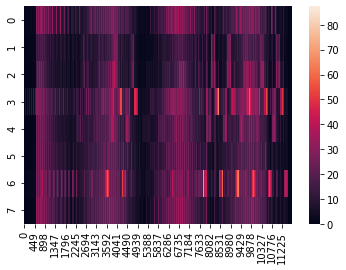

In [40]:
cqt_spec = librosa.feature.chroma_cqt(y=song, sr=sr,hop_length=256, 
                                      n_chroma=n_chroma, n_octaves=7, 
                                      bins_per_octave=n_chroma * 4,
                                      norm=None)
sns.heatmap(cqt_spec)

In [41]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [42]:
if len(ema_encodings) > len(effects_list):
    ema_encodings = ema_encodings[:-1]

  0%|          | 0/2912 [00:00<?, ?it/s]

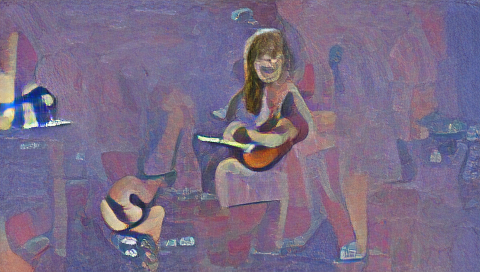

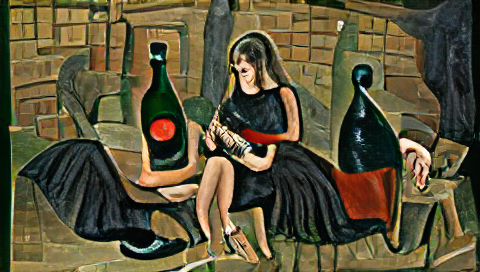

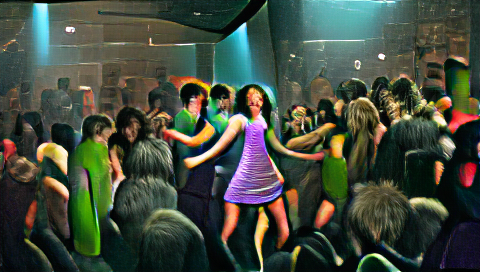

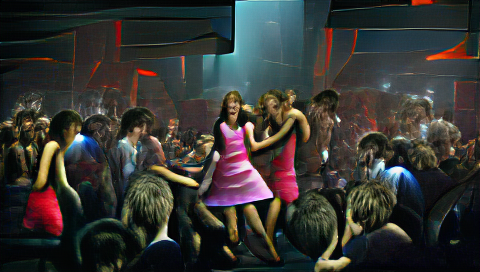

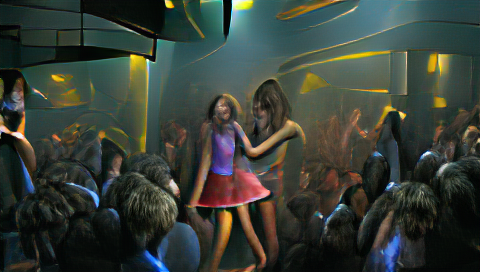

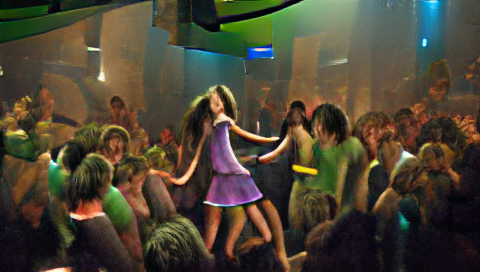

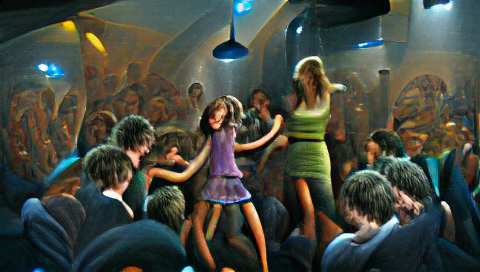

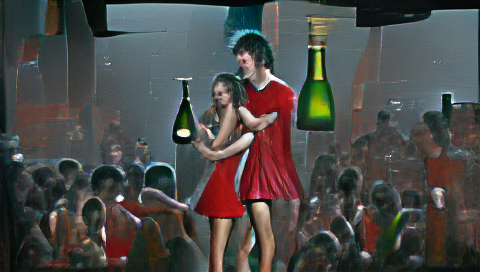

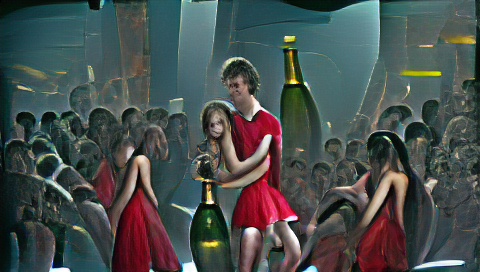

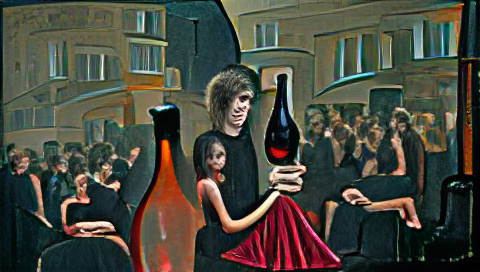

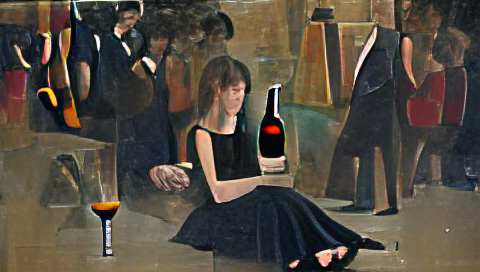

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [43]:
from tqdm.auto import tqdm
import torchvision
import tensorflow as tf
from IPython.display import display, clear_output


assert len(ema_encodings) == len(effects_list)
img_latents = []
img = None
to_pil = torchvision.transforms.ToPILImage()
imagine.to("cuda")
imagine.reset()
transformed_img = None

pbar = tqdm(list(range(len(ema_encodings))))
for i in pbar:
    clip_encoding, effects = ema_encodings[i], effects_list[i]
    # apply effects
    if img is not None:
        transformed_img = img.float()
        for effect in effects:
            transformed_img = effect(transformed_img)
        transformed_img = transformed_img.cuda()
        latent, _, [_, _, indices] = imagine.model.model.model.encode(transformed_img.to(imagine.device).mul(2).sub(1))
        imagine.set_latent(latent)
    # set target encoding in CLIP
    clip_encoding = [part.to(imagine.device) for part in clip_encoding]
    imagine.set_clip_encoding(encoding=clip_encoding)
    # optimize for some steps
    for _ in range(sub_steps):
        img, loss = imagine.train_step(0, 0, lpips_img=transformed_img)
    img = img.detach().cpu()
    # get latent of img
    latent = imagine.model.model.get_latent().detach().cpu()
    img_latents.append(latent)
    # save final img
    if i % (len(ema_encodings) // 20) == 0:
        pil_img = to_pil(img.squeeze())

        display(pil_img)
        #clear_output(wait = True)
    #pbar.update(1)

In [44]:
import torch

def slerp(low, high, val):
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    epsilon = 1e-7
    omega = (low_norm * high_norm).sum(1)
    omega = torch.acos(torch.clamp(omega, -1 + epsilon, 1 - epsilon))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low + (torch.sin(val * omega) / so).unsqueeze(1) * high
    return res

In [45]:
# take ema of encodings to smoothen
ema_latents = []
ema = img_latents[0]
for latent in img_latents:
    ema = ema_val_latent * ema.to("cpu") + (1 - ema_val) * latent.to("cpu")
    ema_latents.append(ema)

In [46]:
# interpolate between latents to increase fps and make video smoother
goal_frame_count = boost_fps * len(song) / 16000
current_frame_count = len(ema_latents)
frames_to_add = np.ceil(goal_frame_count / current_frame_count)
if frames_to_add > 1:
    video_latents = []
    for i, latent in enumerate(ema_latents):
        if i + 1 == len(ema_latents):
            break
        else:
            next_latent = ema_latents[i + 1]
        latents_to_add = [slerp(latent, next_latent, frac) 
                          for frac in np.arange(frames_to_add) / frames_to_add]
        video_latents.extend(latents_to_add)
else:
    video_latents = ema_latents

In [47]:
len(ema_encodings)

2912

In [2]:
import torch
#torch.save(video_latents, "video_latents.pt")
video_latents = torch.load("video_latents.pt")

In [ ]:
import os
import shutil

from PIL import Image
import soundfile
import moviepy.editor as mpy
from datetime import datetime


def load_img_paths(root):
    paths = [os.path.join(root, f) for f in os.listdir(root)
        if f.endswith(".png") or f.endswith(".jpg")]
    paths = sorted(paths, key= lambda x: int(x.split("/")[-1].split("_")[0].split(".")[0]))
    return paths


def create_video(imgs, song, vid_name, sr):
    if isinstance(imgs, list):
        img_len = len(imgs)
    else:
        img_len = len([img for img in os.listdir(imgs) 
                       if img.endswith(".jpg") or img.endswith(".png")])
    vid_fps = len(imgs) * 16000 / len(song)

    # create paths
    date_time = datetime.now().strftime("%m_%d_%H:%M")  #("%m/%d/%Y, %H:%M:%S")
    video_path = f"video_gens/{vid_name}_{args['model_type']}_{date_time}.mp4"
    os.makedirs("video_gens", exist_ok=True)

    # Write temporary audio file
    soundfile.write('tmp.wav', raw_song, old_sr)

    # Generate final video
    audio = mpy.AudioFileClip('tmp.wav', fps=old_sr)
    video = mpy.ImageSequenceClip(imgs, fps=vid_fps)
    video = video.set_audio(audio)
    video.write_videofile(video_path, audio_codec='aac', fps=vid_fps)

    # Delete temporary audio file
    os.remove('tmp.wav')

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# create latents and save to disk:
import torchvision
from tqdm.auto import tqdm
import numpy as np
import shutil

to_pil = torchvision.transforms.ToPILImage()
extension = ".jpg"
tmp_folder = "tmp/vid_imgs" 
shutil.rmtree(tmp_folder)
os.makedirs(tmp_folder, exist_ok=True)
    
for i, latent in enumerate(tqdm(video_latents)):
    imagine.set_latent(latent)
    img = imagine.model.model().to("cpu")
    pil_img = to_pil(img.squeeze())
    pil_img.save(os.path.join(tmp_folder, f"{i}{extension}"), subsampling=0, quality=95)

  0%|          | 0/11644 [00:00<?, ?it/s]

In [ ]:
video_name = f"{song_name.split('/')[-1].split('.')[0]}_{prompt_mode}_ema{ema_val}_steps{sub_steps}"
video_name += gpt_theme if create_gpt_artstyle else ""

paths = load_img_paths(tmp_folder)
create_video(paths, song, video_name, sr)

In [ ]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
#!git clone https://github.com/xinntao/Real-ESRGAN.git
#%cd Real-ESRGAN
# Set up the environment
#!pip install basicsr
#!pip install facexlib
#!pip install gfpgan
#!pip install -r requirements.txt
#!python setup.py develop
# Download the pre-trained model
#!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
#!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth -P experiments/pretrained_models
#%cd ..

In [ ]:
del imagine
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np

import matplotlib.pyplot as plt

@torch.inference_mode()
def upscale_imgs(imgs, out_folder=None, scale=4, tile=0):
    
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, 
                    num_block=23, num_grow_ch=32, scale=scale)
    upsampler = RealESRGANer(
        scale=scale,
        model_path="Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth",
        model=model,
        tile=tile,
        tile_pad=10,
        pre_pad=0,
        half=1)
    
    outs = []
    for i, img in enumerate(tqdm(imgs)):
        if isinstance(img, str):
            img = np.array(Image.open(img))[:,:,::-1]
        
        output, _ = upsampler.enhance(img, outscale=scale)
        pil_img = Image.fromarray(output[:,:,::-1])
        
        if out_folder:
            pil_img.save(os.path.join(out_folder, f"{i}.jpg"), subsample=0, quality=95)
        else:
            outs.append(pil_img)
    return outs


import torchvision

to_tensor = torchvision.transforms.ToTensor()

@torch.inference_mode()
def upscale_imgs_custom(imgs, out_folder=None, scale=4, tile=0):
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, 
                    num_block=23, num_grow_ch=32, scale=scale)
    loadnet = torch.load("Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth")
    if 'params_ema' in loadnet:
        keyname = 'params_ema'
    else:
        keyname = 'params'
    model.load_state_dict(loadnet[keyname], strict=True)
    model.eval().cuda().half()

    outs = []
    for i, img in enumerate(tqdm(imgs)):
        if isinstance(img, str):
            #img = torch.from_numpy(np.ascontiguousarray(Image.open(img))[:,:,::-1].copy()).unsqueeze(0)
            img = torch.from_numpy(np.transpose(np.array(Image.open(img))[:,:,::-1].copy(), (2, 0, 1))).float().unsqueeze(0).to("cuda")
        
        output = model(img.half()).cpu().squeeze().permute(1, 2, 0).numpy()
        #output, _ = upsampler.enhance(img, outscale=scale)
        output = (output * 255.0).round().astype(np.uint8)
        pil_img = Image.fromarray(output[:,:,::-1])
        
        if out_folder:
            pil_img.save(os.path.join(out_folder, f"{i}.jpg"), subsample=0, quality=95)
        else:
            outs.append(pil_img)
    return outs

In [ ]:
#path = [input_paths[1000]]
#print(path)
#upscaled_img = upscale_imgs_custom(path, tile=0)

In [ ]:
#Image.open(path[0])

In [ ]:
import os
import shutil

upscale = True

if upscale:
    input_folder = "tmp/vid_imgs"
    output_folder = "tmp/upscaled_vid_imgs"
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    print("Upscaling...")
    input_paths = load_img_paths(input_folder)
    upscale_imgs(input_paths, out_folder=output_folder, scale=4)
    #!CUDA_VISIBLE_DEVICES=0 python Real-ESRGAN/inference_realesrgan.py --model_path Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth --input $input_folder --output $output_folder  --netscale 4 --outscale 4 --half --face_enhance > /dev/null
    print("Done!")
    # edit name
    upscaled_video_name = video_name.split("/")
    upscaled_video_name[-1] = "HD_" + upscaled_video_name[-1]
    upscaled_video_name = "/".join(upscaled_video_name)
    # create video
    paths = load_img_paths(output_folder)
    create_video(paths, song, upscaled_video_name, sr)

In [ ]:
if twice_upscale:
    torch.cuda.empty_cache()
    gc.collect()
    
    input_folder = "tmp/upscaled_vid_imgs"
    output_folder = "tmp/twice_upscaled_vid_imgs"
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)    
    print("Upscaling...")
    !CUDA_VISIBLE_DEVICES=0 python Real-ESRGAN/inference_realesrgan.py --model_path Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x2plus.pth --input  $input_folder --output $output_folder  --netscale 2 --outscale 2 --half --face_enhance > /dev/null
    print("Done!")
    # edit name
    twice_upscaled_video_name = upscaled_video_name.split("/")
    twice_upscaled_video_name[-1] = "Full" + twice_upscaled_video_name[-1]
    twice_upscaled_video_name = "/".join(twice_upscaled_video_name)
    # create video
    paths = load_img_paths(output_folder)
    create_video(paths, song, twice_upscaled_video_name, sr)

In [ ]:
#!python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus.pth --input "tmp/upscaled_vid_imgs" --output "tmp/twice_upscaled_vid_imgs"  --netscale 4 --outscale 3.5 --half --face_enhance